## Adversarial Validation and Feature Importance

Categorical features: `cp_type`, `cp_time` and `cp_dose` are omitted in adversarial validation. Only gene expression and cell viability features are used. 

Basically we going to replace our targets for both datasets (0 for train and 1 for test), then we going build a classifier which tries to predict which observation belongs to train and which one belongs to test set.

If datasets randomly selected from similar roots it should be really hard for the classifier to separate them.(!!!) But if there is systematic selection differences between train and test sets then classifier should be able to capture this trend. So we want our models score lower for the next section (0.50 AUC) because higher detection rate means higher difference between train and test datasets.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd


DATA_PATH = Path('/Volumes/Samsung_SSD/kaggle_dataset/lish-moa')

In [2]:
train_features = pd.read_csv(DATA_PATH / 'train_features.csv')
test_features = pd.read_csv(DATA_PATH / 'test_features.csv')
train_targets_scored = pd.read_csv(DATA_PATH / 'train_targets_scored.csv')
train_targets_nonscored = pd.read_csv(DATA_PATH / 'train_targets_nonscored.csv')
train_drug = pd.read_csv(DATA_PATH / 'train_drug.csv')

In [7]:
gene_col_names = [_g for _g in train_features.columns if _g.startswith('g-')]
cell_col_names = [_c for _c in train_features.columns if _c.startswith('c-')]

In [9]:
train_features['target'] = 0
test_features['target'] = 1

X = pd.concat([train_features.loc[:, gene_col_names + cell_col_names], 
               test_features.loc[:, gene_col_names + cell_col_names]], ignore_index=True)
y = pd.concat([train_features.loc[:, 'target'], test_features.loc[:, 'target']], ignore_index=True)

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

random_state = 12333
k = 5
kfold = StratifiedKFold(n_splits=k, random_state=random_state, shuffle=True)
oof_predictions = pd.DataFrame(np.zeros((len(X), 1)), columns=['target'])
feature_importance = pd.DataFrame(
    np.zeros((X.shape[1], k)), columns=[f'Fold_{_k}_importance' for _k in range(k)], index=X.columns)

lgbm_params = {
#     'num_iterations': 500, 
#     'early_stopping_round': 50, 
    'num_leaves': 2 ** 5, 
    'learning_rate': 0.05, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 1, 
    'feature_fraction': 0.9, 
    'feature_fraction_bynode': 0.9, 
    'lambda_l1': 0,
    'lambda_l2': 0, 
    'max_depth': -1, 
    'objective': 'binary', 
    'seed': random_state, 
    'feature_fraction_seed': random_state, 
    'bagging_seed': random_state, 
    'drop_seed': random_state, 
    'data_random_seed': random_state, 
    'boosting_type': 'gbdt', 
    'verbose': 1, 
    'metric': 'auc', 
    'n_jobs': -1
}

scores = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), start=1):
    train_data = lgb.Dataset(X.iloc[train_idx, :], label=y.iloc[train_idx])
    val_data = lgb.Dataset(X.iloc[val_idx, :], label=y.iloc[val_idx])
    
    model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, val_data], verbose_eval=50, 
                      early_stopping_rounds=50)
    feature_importance.iloc[:, fold-1] = model.feature_importance(importance_type='gain')
    predictions = model.predict(X.iloc[val_idx], num_iteration=model.best_iteration)
    oof_predictions.loc[val_idx, 'target'] = predictions
    score = roc_auc_score(y, oof_predictions)
    scores.append(score)
    print(f'Fold {fold} - AUC Score {score:.6f}')
    
# for the whole val dataset
oof_score = roc_auc_score(y, oof_predictions)
print(f'Mean, Std AUC between folds: {np.mean(scores):.6f} (+- {np.std(scores):.6f})')
print(f'Overall AUC of val dataset: {oof_score:.6f}')


[LightGBM] [Info] Number of positive: 3185, number of negative: 19051
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 222359
[LightGBM] [Info] Number of data points in the train set: 22236, number of used features: 872
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143236 -> initscore=-1.788667
[LightGBM] [Info] Start training from score -1.788667
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.950452	valid_1's auc: 0.515567
Early stopping, best iteration is:
[21]	training's auc: 0.855743	valid_1's auc: 0.520803
Fold 1 - AUC Score 0.500904
[LightGBM] [Info] Number of positive: 3186, number of negative: 19051
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22236

#### LightGBM Adversarial Validation Model Top 50 Feature Importance (Gain)

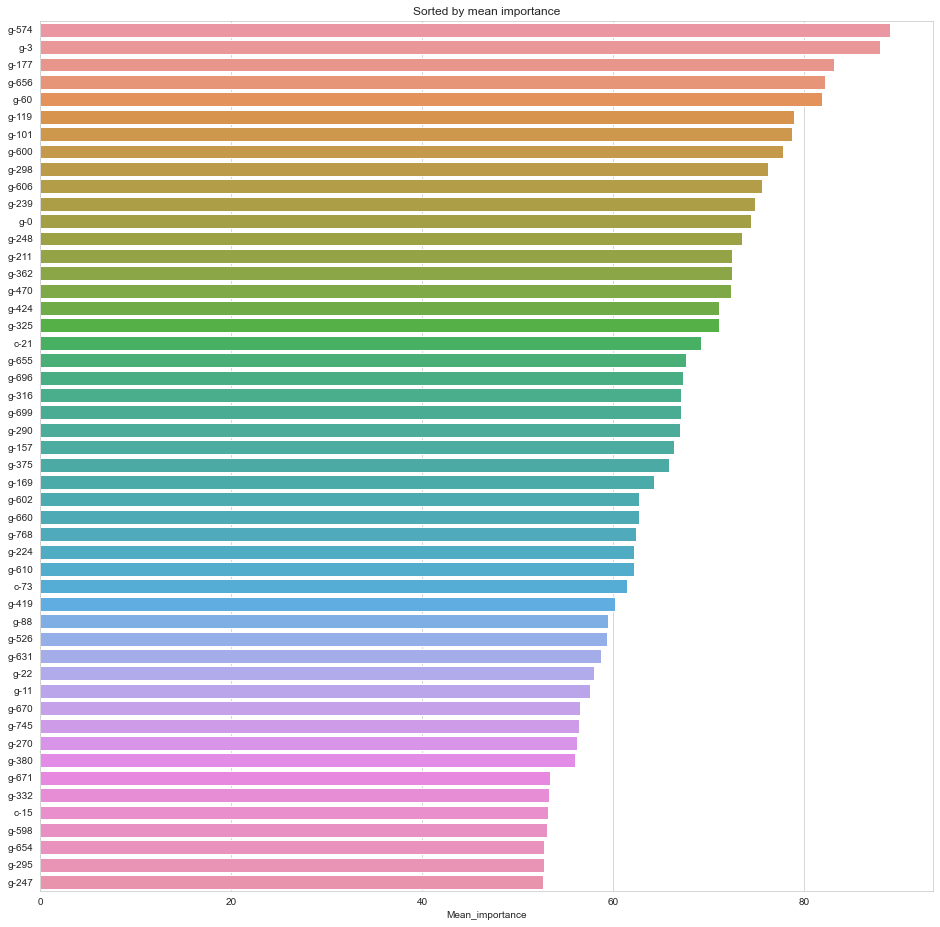

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

feature_importance['Mean_importance'] = feature_importance.mean(axis=1)
feature_importance['Std_importance'] = feature_importance.std(axis=1)
feature_importance_mean = feature_importance.sort_values('Mean_importance', ascending=False)
feature_importance_std = feature_importance.sort_values('Std_importance', ascending=False)

plt.figure(figsize=(16, 16))
sns.barplot(x='Mean_importance', y=feature_importance_mean.index.values[:50], data=feature_importance_mean.iloc[:50])
plt.title('Sorted by mean importance')
plt.show()


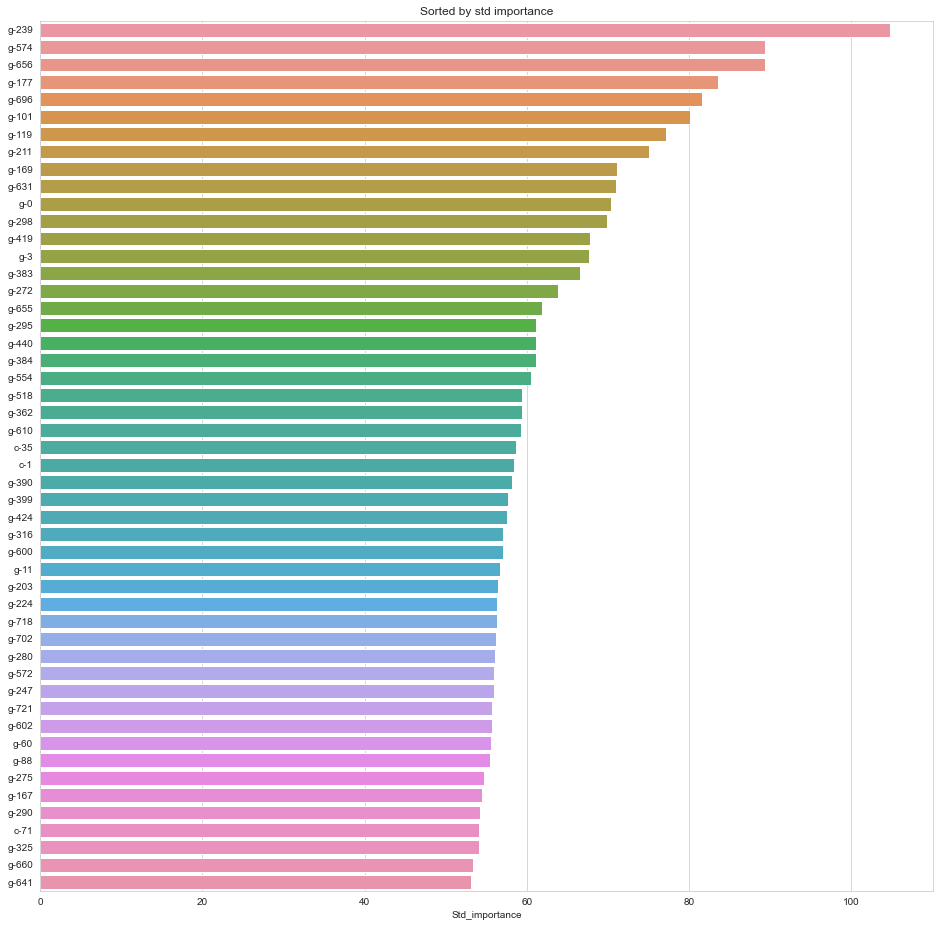

In [39]:
plt.figure(figsize=(16, 16))
sns.barplot(x='Std_importance', y=feature_importance_std.index.values[:50], data=feature_importance_std.iloc[:50])
plt.title('Sorted by std importance')
plt.show()

Adversarial validation model yields approx. 0.525 AUC score which suggests that **training and public test set are similar**. Features at the top of importance plot have higher gain, because they have different means in training and public test set due to distribution tail extremities. This could be related to small sample size of public test set, and it's not necessarily have to be expected in private test set.

In [41]:
# Set random seed
import os
import random
import torch


seed = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed_everything(seed)

## Feature Scaling

It can seen from the prior visualizations that continuous features are between different ranges. Feature scaling can both improve model performance and speed up convergence at the same time. In this competition, **Quantile Transformer** played an important role for scaling of gene and cell features. The reason is this method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, **this transformation tends to spread out the most frequent values**. It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme. Zero centric data perform better in algorithms like PCA, on the other hand min max scaled data may perform better in neural networks.

Min max scaler and standard scaler are heavily affected by outliers, however gaussian rank scaler yields more robust results. Gaussian rank scaled data have symmetrical tails unlike others.

#### Visualize gene/cell features distribution in train set (before quantile transformed)

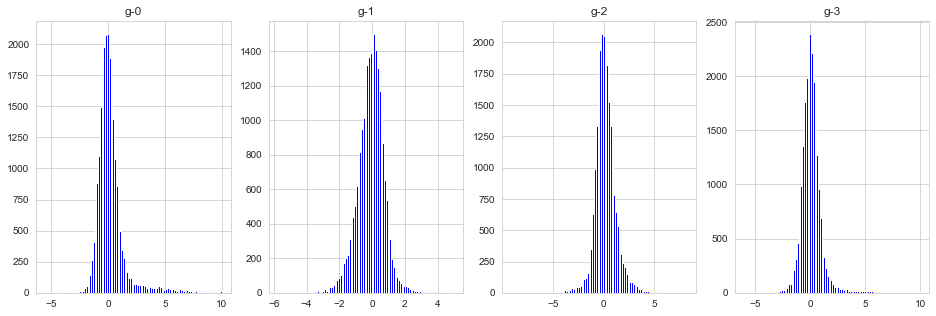

In [44]:
plt.figure(figsize=(16, 5))

gene_choice = list(range(4))
for i, col in enumerate(gene_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features.loc[:, gene_col_names[col]], bins=100, color='blue')
    plt.title(gene_col_names[col])


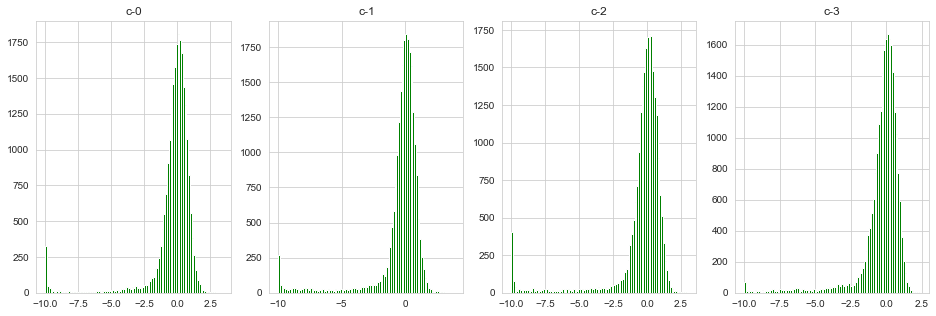

In [45]:
plt.figure(figsize=(16, 5))

cell_choice = list(range(4))
for i, col in enumerate(cell_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features.loc[:, cell_col_names[col]], bins=100, color='green')
    plt.title(cell_col_names[col])


#### Visualize gene/cell features distribution in train set (after quantile transformed)

In [46]:
from sklearn.preprocessing import QuantileTransformer

# Notice: save transformer model
quantile_transformer = QuantileTransformer(n_quantiles=100, random_state=seed, output_distribution='normal')
all_feat_col_names = gene_col_names + cell_col_names
train_features[all_feat_col_names] = quantile_transformer.fit_transform(train_features[all_feat_col_names])
test_features[all_feat_col_names] = quantile_transformer.fit_transform(test_features[all_feat_col_names])


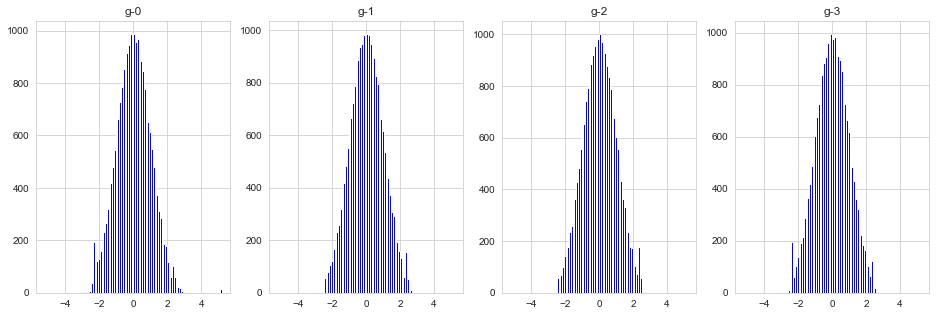

In [47]:
plt.figure(figsize=(16, 5))

gene_choice = list(range(4))
for i, col in enumerate(gene_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features.loc[:, gene_col_names[col]], bins=100, color='blue')
    plt.title(gene_col_names[col])


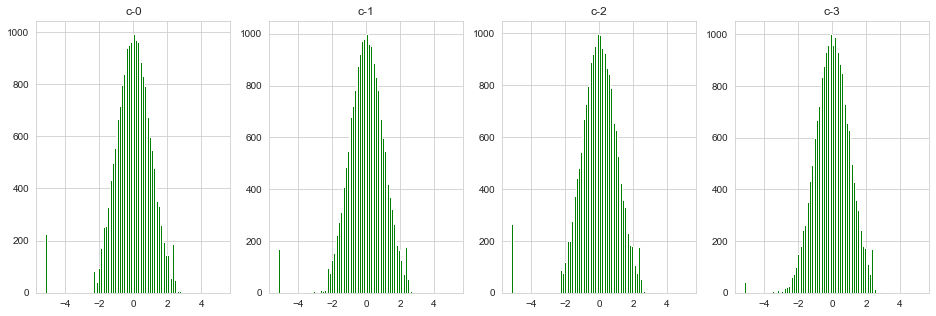

In [48]:
plt.figure(figsize=(16, 5))

cell_choice = list(range(4))
for i, col in enumerate(cell_choice):
    plt.subplot(1, 4, i+1)
    plt.hist(train_features.loc[:, cell_col_names[col]], bins=100, color='green')
    plt.title(cell_col_names[col])


Easy to observe that the normal distribution is obtained.

## Dimensionality Reduction (PCA)

#### PCA for gene features

In [52]:
from sklearn.decomposition import PCA

n_components = 600
# Notice: save pca model
pca_g = PCA(n_components=n_components, random_state=seed)
pca_g.fit(pd.concat([train_features[gene_col_names], test_features[gene_col_names]], ignore_index=True))

train_pca_g = pca_g.transform(train_features[gene_col_names])
test_pca_g = pca_g.transform(test_features[gene_col_names])

train_pca_g = pd.DataFrame(train_pca_g, columns=[f'pca_g_{i}' for i in range(n_components)])
test_pca_g = pd.DataFrame(test_pca_g, columns=[f'pca_g_{i}' for i in range(n_components)])

#### PCA for cell features

In [53]:
from sklearn.decomposition import PCA

n_components = 50    # because of high correlation between feats?
# Notice: save pca model
pca_c = PCA(n_components=n_components, random_state=seed)
pca_c.fit(pd.concat([train_features[cell_col_names], test_features[cell_col_names]], ignore_index=True))

train_pca_c = pca_c.transform(train_features[cell_col_names])
test_pca_c = pca_c.transform(test_features[cell_col_names])

train_pca_c = pd.DataFrame(train_pca_c, columns=[f'pca_c_{i}' for i in range(n_components)])
test_pca_c = pd.DataFrame(test_pca_c, columns=[f'pca_c_{i}' for i in range(n_components)])

In [54]:
train_features = pd.concat((train_features, train_pca_g), axis=1)
test_features = pd.concat((test_features, test_pca_g), axis=1)

train_features = pd.concat((train_features, train_pca_c), axis=1)
test_features = pd.concat((test_features, test_pca_c), axis=1)

## Variance Threshold Feature Selection

If the variance is low or close to zero, then a feature is approximately constant and will not improve the performances of the models. In that case, it should be removed.

In [55]:
print(f'Number of features before Variance thresholding - {train_features.shape[1]}')

Number of features before Variance thresholding - 1527


In [58]:
gene_col_names_pca = [_g for _g in train_features.columns if _g.startswith('g-') or _g.startswith('pca_g')]
cell_col_names_pca = [_c for _c in train_features.columns if _c.startswith('c-') or _c.startswith('pca_c')]
all_feat_col_names_pca = gene_col_names_pca + cell_col_names_pca
info_col_names = ['sig_id', 'cp_type', 'cp_time', 'cp_dose']

In [66]:
var_thresh = 0.85

train_all_feat_pca = train_features[all_feat_col_names_pca]
test_all_feat_pca = test_features[all_feat_col_names_pca]

var_mask = train_all_feat_pca.var() >= var_thresh
train_features = pd.concat([train_all_feat_pca.loc[:, var_mask], train_features[info_col_names]], axis=1)

var_mask = test_all_feat_pca.var() >= var_thresh
test_features = pd.concat([test_all_feat_pca.loc[:, var_mask], test_features[info_col_names]], axis=1)

In [67]:
print(f'Number of features after Variance thresholding - {train_features.shape[1]}')

Number of features after Variance thresholding - 1028


## K-Means Clustering
The objective of K-Means is simple: group similar data points together and discover underlying patterns. K-Means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. The 'means' in the K-Means refers to averaging of the data; that is, finding the centroid.

!! Not applied to PCA feats

As this is a multi-label problem. Applying K-Means maybe beneficial.

In [69]:
from sklearn.cluster import KMeans

n_clusters_g = 22
n_clusters_c = 4

kmeans_g = KMeans(n_clusters=n_clusters_g, random_state=seed).fit(
    pd.concat([train_features[gene_col_names], test_features[gene_col_names]]))
kmeans_c = KMeans(n_clusters=n_clusters_c, random_state=seed).fit(
    pd.concat([train_features[cell_col_names], test_features[cell_col_names]]))

train_km_g = kmeans_g.predict(train_features[gene_col_names])
test_km_g = kmeans_g.predict(test_features[gene_col_names])
train_km_c = kmeans_c.predict(train_features[cell_col_names])
test_km_c = kmeans_c.predict(test_features[cell_col_names])


In [72]:
df_train_km_g = pd.get_dummies(train_km_g)
df_train_km_g.columns = [f'cluster_g_{_k}' for _k in range(n_clusters_g)]

df_test_km_g = pd.get_dummies(test_km_g)
df_test_km_g.columns = [f'cluster_g_{_k}' for _k in range(n_clusters_g)]

df_train_km_c = pd.get_dummies(train_km_c)
df_train_km_c.columns = [f'cluster_c_{_k}' for _k in range(n_clusters_c)]

df_test_km_c = pd.get_dummies(test_km_c)
df_test_km_c.columns = [f'cluster_c_{_k}' for _k in range(n_clusters_c)]

In [75]:
train_features = pd.concat([train_features, df_train_km_g, df_train_km_c], axis=1)
test_features = pd.concat([test_features, df_test_km_g, df_test_km_c], axis=1)

## New features generation

Use statistical features and pairs of highly correlated features.

In [76]:
for df in train, test:
    df['g_sum'] = df[features_g].sum(axis = 1)
    df['g_mean'] = df[features_g].mean(axis = 1)
    df['g_std'] = df[features_g].std(axis = 1)
    df['g_kurt'] = df[features_g].kurtosis(axis = 1)
    df['g_skew'] = df[features_g].skew(axis = 1)
    df['c_sum'] = df[features_c].sum(axis = 1)
    df['c_mean'] = df[features_c].mean(axis = 1)
    df['c_std'] = df[features_c].std(axis = 1)
    df['c_kurt'] = df[features_c].kurtosis(axis = 1)
    df['c_skew'] = df[features_c].skew(axis = 1)
    df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
    df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
    df['gc_std'] = df[features_g + features_c].std(axis = 1)
    df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
    df['gc_skew'] = df[features_g + features_c].skew(axis = 1)

    # Using pair of highly correlative features

    df['c52_c42'] = df['c-52'] * df['c-42']
    df['c13_c73'] = df['c-13'] * df['c-73']
    df['c26_c13'] = df['c-26'] * df['c-13']
    df['c33_c6'] = df['c-33'] * df['c-6']
    df['c11_c55'] = df['c-11'] * df['c-55']
    df['c38_c63'] = df['c-38'] * df['c-63']
    df['c38_c94'] = df['c-38'] * df['c-94']
    df['c13_c94'] = df['c-13'] * df['c-94']
    df['c4_c52'] = df['c-4'] * df['c-52']
    df['c4_c42'] = df['c-4'] * df['c-42']
    df['c13_c38'] = df['c-13'] * df['c-38']
    df['c55_c2'] = df['c-55'] * df['c-2']
    df['c55_c4'] = df['c-55'] * df['c-4']
    df['c4_c13'] = df['c-4'] * df['c-13']
    df['c82_c42'] = df['c-82'] * df['c-42']
    df['c66_c42'] = df['c-66'] * df['c-42']
    df['c6_c38'] = df['c-6'] * df['c-38']
    df['c2_c13'] = df['c-2'] * df['c-13']
    df['c62_c42'] = df['c-62'] * df['c-42']
    df['c90_c55'] = df['c-90'] * df['c-55']
    df['c26_c38'] = df['c-26'] * df['c-38']
    df['c90_c13'] = df['c-90'] * df['c-13']
    df['c85_c31'] = df['c-85'] * df['c-31']
    df['c63_c42'] = df['c-63'] * df['c-42']
    df['c94_c11'] = df['c-94'] * df['c-11']
    df['c94_c60'] = df['c-94'] * df['c-60']
    df['c55_c42'] = df['c-55'] * df['c-42']
    df['g37_c50'] = df['g-37'] * df['g-50']


NameError: name 'train' is not defined